In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Google Drive Mount
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


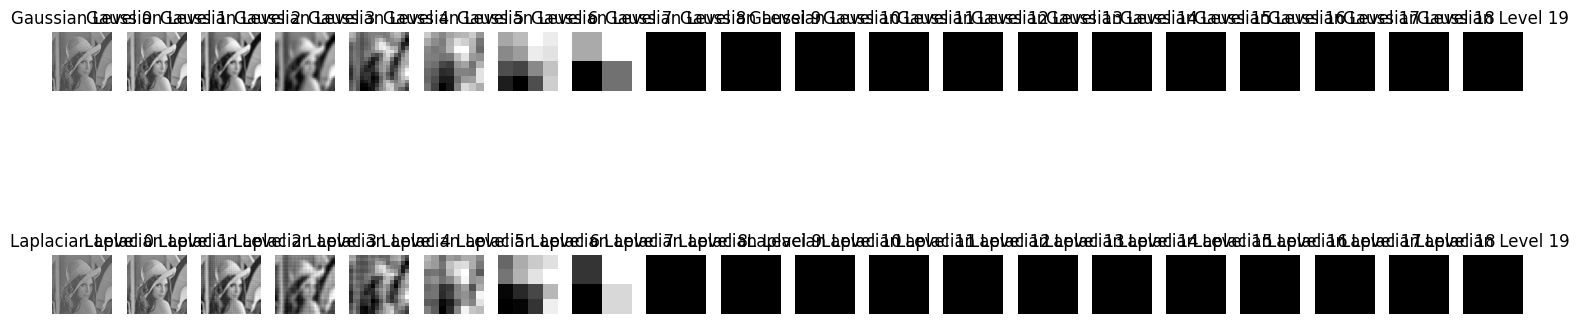

In [5]:
def apply_gaussian_blur(image, kernel_size=5, sigma=1.5):
    ax = np.linspace(-(kernel_size - 1) / 2., (kernel_size - 1) / 2., kernel_size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5 * (xx**2 + yy**2) / sigma**2)
    kernel /= kernel.sum()

    pad_width = kernel_size // 2
    padded_image = np.pad(image, pad_width, mode='reflect')
    output = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            output[i, j] = np.sum(padded_image[i:i+kernel_size, j:j+kernel_size] * kernel)
    return output

def downsample(image):
    return image[::2, ::2]

def upsample(image, target_shape):
    result = np.zeros(target_shape)
    result[::2, ::2] = image
    return apply_gaussian_blur(result, kernel_size=5, sigma=1.5)

def create_gaussian_pyramid(image, levels):
    gaussian_pyramid = [image]
    for _ in range(1, levels):
        image = apply_gaussian_blur(image)
        image = downsample(image)
        gaussian_pyramid.append(image)
    return gaussian_pyramid

def create_laplacian_pyramid(gaussian_pyramid):
    laplacian_pyramid = []
    for i in range(len(gaussian_pyramid)-1):
        upsampled = upsample(gaussian_pyramid[i+1], gaussian_pyramid[i].shape)
        laplacian_layer = gaussian_pyramid[i] - upsampled
        laplacian_pyramid.append(laplacian_layer)
    laplacian_pyramid.append(gaussian_pyramid[-1])
    return laplacian_pyramid

# Load the image
#noisy_img = cv2.imread('lena_gray_256_noisy.png', cv2.IMREAD_GRAYSCALE)

image_path = 'lena_gray_256_noisy.png'
image = Image.open(image_path).convert('L')
image_np = np.array(image)

# Create Gaussian and Laplacian pyramids
gaussian_pyramid = create_gaussian_pyramid(image_np, levels=20)
laplacian_pyramid = create_laplacian_pyramid(gaussian_pyramid)

# Display all levels of the Gaussian and Laplacian pyramids
fig, axs = plt.subplots(2, len(gaussian_pyramid), figsize=(15, 6))

for i, (gauss, laplace) in enumerate(zip(gaussian_pyramid, laplacian_pyramid)):
    axs[0, i].imshow(gauss, cmap='gray')
    axs[0, i].set_title(f'Gaussian Level {i}')
    axs[0, i].axis('off')

    axs[1, i].imshow(laplace, cmap='gray')
    axs[1, i].set_title(f'Laplacian Level {i}')
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

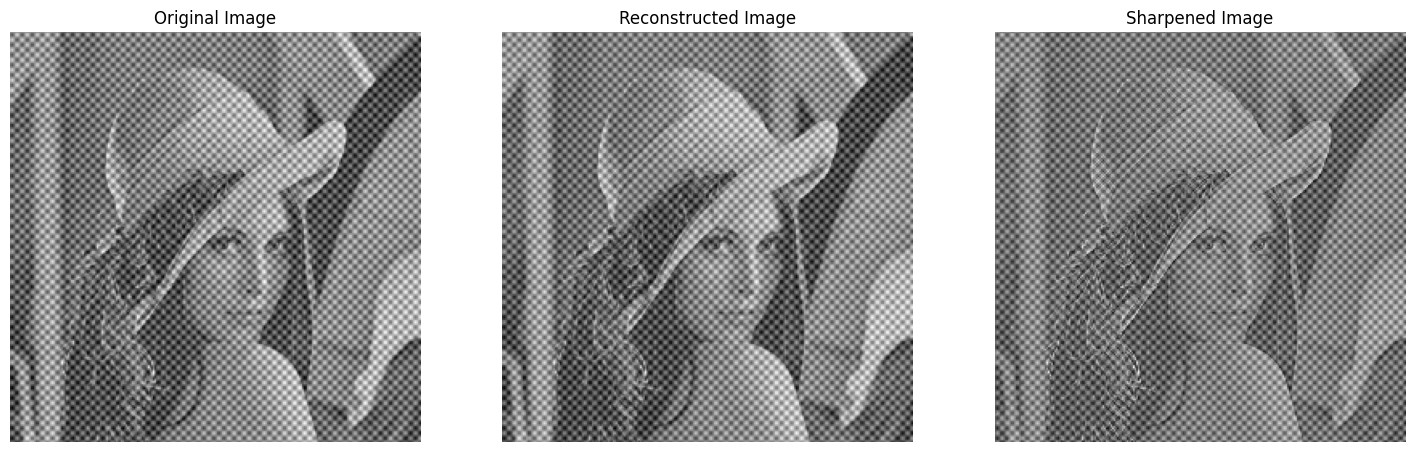

In [14]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def apply_sharpening(image, alpha=1.5):
    # A simple sharpening filter: enhances edges by adding a scaled Laplacian to the original image
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    pad_width = 1
    padded_image = np.pad(image, pad_width, mode='reflect')
    sharpened_image = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            sharpened_image[i, j] = np.sum(padded_image[i:i+3, j:j+3] * kernel) + alpha * image[i, j]
    return sharpened_image

def reconstruct_from_laplacian_pyramid(laplacian_pyramid, damping_factor=0.1):
    image = laplacian_pyramid[-1]
    for i in range(len(laplacian_pyramid)-2, -1, -1):
        image = upsample(image, laplacian_pyramid[i].shape)
        high_freq = laplacian_pyramid[i] * damping_factor
        image += high_freq
    return image

# Load the image
image_path = 'lena_gray_256_noisy.png'
image = Image.open(image_path).convert('L')
image_np = np.array(image)

# Create Gaussian and Laplacian pyramids
gaussian_pyramid = create_gaussian_pyramid(image_np, levels=4)
laplacian_pyramid = create_laplacian_pyramid(gaussian_pyramid)
reconstructed_image = reconstruct_from_laplacian_pyramid(laplacian_pyramid, damping_factor=0.1)

# Apply sharpening to the reconstructed image
sharpened_image = apply_sharpening(reconstructed_image, alpha=1.2)

# Display the original, reconstructed, and sharpened images
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.imshow(image_np, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

plt.subplot(133)
plt.imshow(sharpened_image, cmap='gray')
plt.title('Sharpened Image')
plt.axis('off')

plt.show()
